# CSCI6908: Assignment 4 - GPT from Scratch.

**<span style="color:red">Deadline: Monday, March 17th, 2025</span>**

# Part 0: Introduction

During the lecture, you have covered the Transformers architecture. Such architecture represents the backbone of many state-of-the-art large language models. In this assignment you will implement from scratch a Generative Pre-trained Transformer (GPT) model, which is nothing but a decoder-only Transformer. You will implement from scratch using `pytorch` the different building blocks that constitute the GPT model.  

This assignment assumes some familiarity with the framework. You can consult `pytorch`'s [documentation](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) to brush up on your knowledge.  

The main goals of this assignment are:  
  - Implement the Causal Self-Attention layer and use it to form the Multihead-Attention block.
  - Implement contemporary activation functions used in modern day language models.
  - Implement the GPT model and its subcomponents.
  - Pre-train a generative model from scratch.

## Requirements
Before you can start, make sure you install the dependencies list in the `requirements.txt` file. It is advised that you use a Python virtual enviornment. You can consult how you can a add virtual enviornment to Jupyter's kernal through this [guide](https://janakiev.com/blog/jupyter-virtual-envs/).  
In this assignment you will train a GPT model for a duration of at least $20K$ steps (not epochs). If you do not have access to enough computational resources here are your options:
- Use a configuration that yields a smaller GPT model. For instance, use only $4$ layers instead of $6$.
- Use [Google Colab](https://colab.research.google.com/).
- Use Dal's Brookside and Calvert [servers](https://www.dal.ca/faculty/computerscience/for-faculty-staff/technical-services.html). Check under _Academic compute enviornment_ > _GPU Processing_. There you will find links that redirect you to the Jupyter lab interface hosted on these servers.

**Please note that your grade will depend on the implementation and not on the running results. Hence, if you cannot train these models fully, you can still get the full grade if your implementation is correct.**

## Submission Guidelines
Add the TA as _Maintainer_ to your fork and submit your fork's URL on Brightspace. Push the modifications you have made on this notebook to your fork.  

## Submission of SDAs
For this assignment, SDAs should be submitted through Brightspace. You will find the submission box under _Assignments_ > _SDA_. **<span style="color:red">Please note that you are only allowed to submit 2 SDAs for this course. Hence, if you already reached that limit, you can no longer submit one. In addition, no SDA will be considered if sent by email. All SDAs should be submitted through Brightspace at least 24 hours prior to the deadline. The PDF file should be following this format: `<BANNER-ID>_<FIRST-NAME>_<LAST_NAME>_<ASSIGNMENT-NUMBER>.pdf`</span>**  

If you have any questions, please do not hesitate to post them on the course’s Teams channel. If you have not joined already, you can do so by using this code: `ot45hmp`.

Good luck!

## Part 1: Multihead-Self Attention

<center><img src="https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png" align="center" width="350px">
</center>
Source: Vaswani *et al.*


In [ ]:
# Imports
import torch.nn as nn
import torch
import torch.nn.functional as F

### Part 1.1: Causal Self-attention Layer:

The Causal Self-attention layer is a fundamental building block of the GPT (Generative Pre-trained Transformer) architecture. This layer consists of several key components that work together to enable the model to focus on relevant parts of the input sequence while maintaining the autoregressive property. The main components of a causal self-attention head are:  


1. Linear projections: Three separate linear transformations are applied to the input to create the query ($Q$), key ($K$), and value ($V$) matrices: $Q = XW_q, K = XW_k, V = XW_v$ where $X$ is the input tensor, and $W_q$, $W_k$, and $W_v$ are learnable weight matrices.

2. Scaled dot-product attention: The attention mechanism is computed as: $\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}} + M\right)V$ where $d_k$ is the dimensionality of the key vectors, and $M$ is the causal mask.

3. Causal masking: A lower triangular matrix $M$ is applied to ensure that each token can only attend to itself and previous tokens: $M_{ij} = \begin{cases} 0 & \text{if } i \geq j \ -\infty & \text{if } i < j \end{cases}$


These components work together to create a causal self-attention mechanism that captures dependencies between tokens while respecting the sequential nature of the input, which is crucial for language modeling tasks.

#### Tasks

Complete the implementation of the `__init__` and `forward` functions of the `CausalSelfAttention`.  
**Note that you are only allowed to use the following `pytorch` APIs: `nn.Linear`, `nn.Dropout`, `torch.softmax`/`nn.Softmax`. You are allowed to use all tensor operations such as .transpose(), .size() and so on**.

In [ ]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
      """
      d_in: embedding dimension
      d_out: embedding dimension
      context_length: maxmimum number of tokens in the sequence
      dropout: dropout rate
      qkv_bias: flag to whether use bias for the query, key and value layers or not.
      """
      super().__init__()
      # Define the netowrk structure here
      self.query = nn.Linear(d_in, d_out, bias=qkv_bias)
      self.key = nn.Linear(d_in, d_out, bias=qkv_bias)
      self.value = nn.Linear(d_in, d_out, bias=qkv_bias)
      self.attn_dropout = nn.Dropout(dropout)
      
      self.register_buffer(
          "mask", 
          torch.tril(torch.ones(context_length, context_length))
      )
      
      self.d_out = d_out

    def forward(self, x):
      batch_size, seq_len, d_in = x.size()
        
      q = self.query(x) # (batch_size, seq_len, d_out)
      k = self.key(x)   
      v = self.value(x)  
      
      attn_scores = (q @ k.transpose(-2, -1)) / (self.d_out ** 0.5)
    
      causal_mask = self.mask[:seq_len, :seq_len]
      
      attn_scores = attn_scores.masked_fill(causal_mask == 0, float('-inf'))
      
      attn_weights = torch.softmax(attn_scores, dim=-1)
      
      attn_weights = self.attn_dropout(attn_weights)
      
      output = attn_weights @ v 
      
      return output

### Part 1.2: Multihead Self-attention Layer

Multihead Self-attention extends the concept of single-head attention by allowing the model to jointly attend to information from different representation subspaces at different positions. It enhances the model's capability to capture diverse relationships within the input sequence by employing multiple attention heads in parallel. Each head operates independently, allowing the model to focus on different aspects of the input simultaneously. The output of this layer is calculated as follows:

$\text{MultiHead}(X) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O$

Where $h$ is the number of attention heads, and $W^O \in \mathbb{R}^{hd_v \times d_{model}}$ is the output projection matrix.

#### Tasks
Complete the implementation of the `__init__` and `forward` functions of the `MultiHeadAttention` class.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
      """
      d_in: embedding dimension
      d_out: embedding dimension of one attention head
      context_length: maxmimum number of tokens in the sequence
      dropout: dropout rate
      num_heads: number of heads
      qkv_bias: flag to whether use bias for the query, key and value layers or not.
      """
      super().__init__()
      # Define the netowrk structure here
      self.num_heads = num_heads
      self.d_out = d_out
      
      # Create multiple attention heads
      self.heads = nn.ModuleList([
          CausalSelfAttention(d_in, d_out, context_length, dropout, qkv_bias)
          for _ in range(num_heads)
      ])
      
      self.output_projection = nn.Linear(d_out * num_heads, d_in)
      
      self.dropout = nn.Dropout(dropout)

    def forward(self, x):
      head_outputs = [head(x) for head in self.heads]
        
      multihead_output = torch.cat(head_outputs, dim=-1)
      
      output = self.output_projection(multihead_output)
      
      output = self.dropout(output)
      
      return output

Sanity check.

In [ ]:
torch.manual_seed(123)
vocab_size = 50257
context_length = 512
d_in = 256
num_heads = 4
d_out = d_in // num_heads
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads)

sample_input = torch.randn(1, context_length, d_in)

context_vecs = mha(sample_input)
assert context_vecs.shape == (1, context_length, d_out * num_heads)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([1, 512, 256])


## Part 2: GELU Activation Function

The Gaussian Error Linear Unit (GELU) is an activation function that is used in modern Transformer-based models. Originally, Transformers used the Rectified Linear Unit (ReLU) as their activation function. This activation function is used in the Feedforward network that you will implement later in the assignment. GELU can be mathematically expressed as:

$\text{GELU}(x) = x \cdot \Phi(x)$

where $\Phi(x)$ is the cumulative distribution function of the standard normal distribution. In practice, we often use an approximation of GELU rather than the exact formula involving the CDF. This approximation is computationally more efficient and easier to implement, while still capturing the essential behavior of GELU. 

#### Tasks
In the below code cell, complete the implementation of the `forward` method of the `GELU` activation function class using the first approxmiation formula given by [(Hendrycks and Gimpel, 2020)](https://arxiv.org/abs/1606.08415) (the one that that starts with $0.5x$).

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


## Part 3: LayerNorm

Layer Normalization (LayerNorm) is a crucial technique that stabilizes the learning process. It operates on the feature dimension. For an input $x \in \mathbb{R}^{d}$, LayerNorm is defined as:

$\text{LayerNorm}(x) = \gamma \odot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$

where $\mu = \frac{1}{d}\sum_{i=1}^d x_i$ is the mean, $\sigma^2 = \frac{1}{d}\sum_{i=1}^d (x_i - \mu)^2$ is the variance, $\epsilon$ is a small constant for numerical stability (typically $10^{-5}$), $\gamma$ and $\beta$ are learnable scale and shift parameters respectively, and $\odot$ denotes element-wise multiplication.

#### Tasks
Complete the implementation of the `__init__` and `forward` functions of the `LayerNorm` class.  
**Hint:** In `pytorch`, `nn.Parameter` is used to defined learnbale parameters.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # Define the netowrk structure here
        self.gamma = nn.Parameter(torch.ones(hidden_dim))
        self.beta = nn.Parameter(torch.zeros(hidden_dim))
        self.eps = 1e-5

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, unbiased=False, keepdim=True)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x_norm + self.beta

## Part 4: Feeforward Network

The Feedforward Network (FFN) is a main component in each Transformer block, applied after the MHA layer. It consists of two linear transformations with a non-linear activation function in between, which in modern implementations is often the Gaussian Error Linear Unit (GELU) that you implemented earlier. The FFN is expressed as:

$\text{FFN}(x) = \text{GELU}(xW_1 + b_1)W_2 + b_2$

where $x \in \mathbb{R}^{d_\text{model}}$ is the input, $W_1 \in \mathbb{R}^{d_\text{model} \times d_\text{ff}}$, $W_2 \in \mathbb{R}^{d_\text{ff} \times d_\text{model}}$ are weight matrices, and $b_1, b_2$ are bias vectors. In your implementation make sure that $d_\text{ff} = 4\times d_\text{model}$. For more clarity, $d_\text{model}$ is also referred to as the hidden layer dimension.

#### Tasks
Complete the implementation of the `__init__` and `forward` functions of the `FeeForward` class. 

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        # Define the netowrk structure here
        d_ff = 4 * d_in
        self.fc1 = nn.Linear(d_in, d_ff)  
        self.gelu = GELU()                
        self.fc2 = nn.Linear(d_ff, d_out)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x

## Part 5: The Transformer Layer and the GPT model

At this stage, you have implemented all the building blocks that constitute the Transformer layer. Your task now is to assemble this layer using these blocks. Use the following illustration as a guideline to help you do so.
<center><img src="https://i.imgur.com/TpHBi7y.png" align="center" width="250px">
</center>

**N.B:** The Postional and Input Embedding layers are not part of the Transformer layer. You will later define those when building the GPT model. **In addition, although the figure taken from the work of Vaswani et. al show a softmax layer at the end, the implementation of the GPT model should NOT include it. The reason is the loss function that will be used to pre-train the model accepts logits and then applies softmax. Hence, if you apply softmax, you would be applying it twice.**

Finish the implementation of the `__init__` and `forward` functions.

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads ,dropout):
        super().__init__()
        # Define the netowrk structure here: MHA, FFNN, LayerNorm1, LayerNorm2
        head_dim = d_in // num_heads
        
        self.ln1 = LayerNorm(d_in)
        self.ln2 = LayerNorm(d_in)
        
        self.attention = MultiHeadAttention(
            d_in=d_in,
            d_out=head_dim,
            context_length=context_length,
            dropout=dropout,
            num_heads=num_heads
        )
        
        self.feedforward = FeedForward(d_in=d_in, d_out=d_out)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.attention(self.ln1(x)))
        x = x + self.dropout(self.feedforward(self.ln2(x)))
        return x

Finish the implementation of the `__init__` and `forward` functions of the full GPT model.

In [ ]:
class GPT(nn.Module):
    def __init__(self, vocab_size, d_in, d_out, context_length, num_heads, num_layers, dropout):
        super().__init__()
       
        self.embedding = nn.Embedding(vocab_size, d_in)
        self.pos_embedding = nn.Embedding(context_length, d_out)
        self.layers = nn.ModuleList([
            TransformerLayer(
                d_in=d_in, 
                d_out=d_out, 
                context_length=context_length, 
                num_heads=num_heads, 
                dropout=dropout
            ) for _ in range(num_layers)
        ])
        
        self.ln_f = LayerNorm(d_out)
        
        self.lm_head = nn.Linear(d_out, vocab_size, bias=False)
        
        self.lm_head.weight = self.embedding.weight
        
        self.context_length = context_length

    def forward(self, x):
        batch_size, seq_len = x.size()

        token_embeddings = self.embedding(x)  
        positions = torch.arange(0, seq_len, dtype=torch.long, device=x.device)
        position_embeddings = self.pos_embedding(positions)  
        x = token_embeddings + position_embeddings

        for layer in self.layers:
            x = layer(x)

        x = self.ln_f(x)

        logits = self.lm_head(x)

        return logits



## Part 6: Data Preparation and Model Pretraining

At this stage, you have implemented the entire GPT model from scratch. Now it is time to implement the pretraining logic. This includes: data loading, data preparation, model pre-training and evaluation. In terms of pre-training data, you will need to use the Shakespeare dataset that can be found in `data/shakespeare.txt`. 

### Tasks

In this last major part of the assignment, you will need to implement these steps: 
- Using `vocab.py` from Assignment 3 and the `subword_nmt` Python package, build a vocabulary of size at least `4000`.
- Initialize a GPT model with your own choice of hyperparameters (_e.g._, number of layers, number of attention heads, hidden size dimension and so on). Note that the bigger the model the more compute you will need. For this reason, the model architecture is up to you.
- The pre-training objective is _next token prediction_, when given a sequence $[w_1, w_2, ..., w_n]$ the model should predict the token $w_{n+1}$. This is important when preparing data into a proper format that can be fed to the model.
- You will need to use the `F.cross_entropy` method provided by `pytorch` that calculates the cross-entropy loss.  
- Use the AdamW optimizer to update the model's parameters. It can be imported from the `torch.optim.AdamW` package.
- Implement the training loop that runs for at least $20K$ training steps.
- Plot the training loss curve. You can do this after each specified number of steps or once the training finishes. However, the former strategy is recommended to monitor the training status of your model.
- Run inference by feeding the model a prefix and see what tokens it can generate.

In [ ]:
### Your code goes here
import math
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from vocab import Vocab
import numpy as np
from IPython.display import clear_output

In [ ]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        return [line.strip().lower() for line in f.readlines()]

def build_vocabulary(data, vocab_size):
    
    with open('temp_bpe_codes.txt', 'w') as codes:
        learn_bpe(data, codes, vocab_size)
    
    with open('temp_bpe_codes.txt', 'r') as codes:
        bpe = BPE(codes)
    
    tokenized_data = [bpe.process_line(line) for line in data]
    
    vocab = Vocab.from_lines(tokenized_data)
    
    return vocab, bpe, tokenized_data

def prepare_data(tokenized_data, vocab, context_length):

    all_tokens = ' '.join(tokenized_data).split()
    
    token_indices = [vocab.token_to_ix.get(token, vocab.unk_ix) for token in all_tokens]
    
    inputs = []
    targets = []
    
    for i in range(0, len(token_indices) - context_length):
        inputs.append(token_indices[i:i + context_length])
        targets.append(token_indices[i + 1:i + context_length + 1])
    
    return torch.tensor(inputs), torch.tensor(targets)

def get_random_batch(inputs, targets, batch_size):
        total_samples = inputs.shape[0]
        
        random_indices = torch.randperm(total_samples)[:batch_size]
        
        # Select random batch
        batch_inputs = inputs[random_indices]
        batch_targets = targets[random_indices]
        
        return batch_inputs, batch_targets

In [ ]:
def compute_loss(logits, targets):

        batch_size, seq_len = targets.shape
        mask = torch.zeros_like(targets, dtype=torch.bool)

        for i in range(batch_size):
                eos_positions = (targets[i] == 1).nonzero(as_tuple=True)[0]
                if len(eos_positions) > 0:
                        first_eos_pos = eos_positions[0].item()
                        mask[i, :first_eos_pos+1] = True
                else:
                        mask[i, :] = True

        mask = mask.float()

        logits_flat = logits.view(-1, logits.size(-1))
        targets_flat = targets.view(-1)
        mask_flat = mask.view(-1)

        loss_per_token = F.cross_entropy(logits_flat, targets_flat, reduction='none')

        masked_loss = loss_per_token * mask_flat

        total_loss = masked_loss.sum()

        total_tokens = mask.sum()

        average_loss = total_loss / total_tokens

        return average_loss

In [ ]:
def train_gpt(model, inputs, targets, batch_size, lr, num_steps):

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    metrics = {'train_loss': []}
    model.train()
    pbar = tqdm(range(num_steps))
    
    for _ in pbar:
        batch_inputs, batch_targets = get_random_batch(inputs, targets, batch_size)
                
        step = len(metrics['train_loss']) + 1
        logits = model(batch_inputs)

        optimizer.zero_grad()
        loss = compute_loss(logits, batch_targets)
        loss.backward()
        optimizer.step()
        
        metrics['train_loss'].append(loss.item())
        
        if step % 100 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(10, 5))
            plt.plot(metrics['train_loss'])
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.show()
            print("Mean Loss=%.3f" % np.mean(metrics['train_loss'][-10:]))
    
    return metrics

vocab_size = 5000
context_length = 128
d_in = 256
d_out = 256
num_heads = 4
num_layers = 4
dropout = 0.1
batch_size = 32
learning_rate = 1e-3
num_steps = 22000

data = load_data('data/shakespeare.txt')

vocab, bpe, tokenized_data = build_vocabulary(data, vocab_size)

inputs, targets = prepare_data(tokenized_data, vocab, context_length)

100%|██████████| 5000/5000 [00:02<00:00, 1970.60it/s]


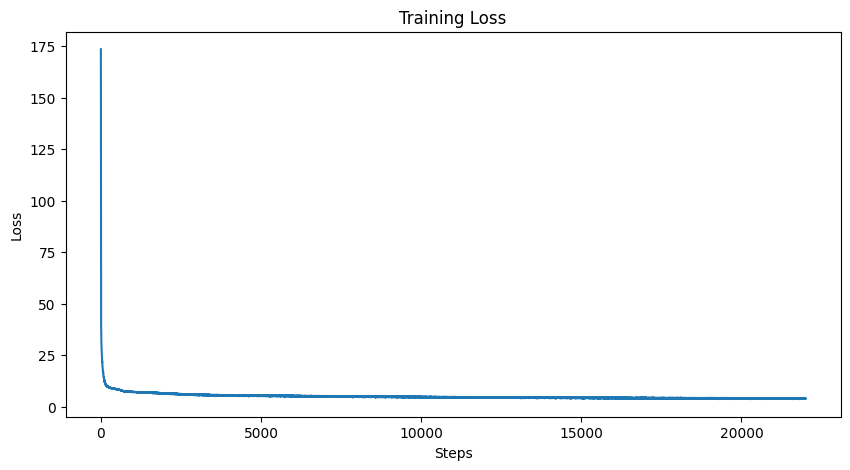

100%|██████████| 22000/22000 [10:16:24<00:00,  1.68s/it]

Mean Loss=3.988


In [ ]:
model = GPT(
    vocab_size=len(vocab),
    d_in=d_in,
    d_out=d_out,
    context_length=context_length,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout
)

metrics = train_gpt(model, inputs, targets, batch_size, learning_rate, num_steps)

In [ ]:
def generate_text(model, prefix, vocab, bpe, max_length=100, temperature=1.0):

    model.eval()
    
    prefix_tokens = bpe.process_line(prefix.lower()).split()
    input_ids = [vocab.token_to_ix.get(token, vocab.unk_ix) for token in prefix_tokens]
    
    if len(input_ids) > model.context_length:
        input_ids = input_ids[-model.context_length:]
    
    while len(input_ids) < model.context_length:
        input_ids.insert(0, vocab.bos_ix)
    
    input_tensor = torch.tensor([input_ids])
    
    generated_tokens = []
    with torch.no_grad():
        for _ in range(max_length):
            logits = model(input_tensor)
            
            next_token_logits = logits[0, -1, :] / temperature
            
            probs = F.softmax(next_token_logits, dim=-1)
            
            next_token = torch.multinomial(probs, 1).item()
            
            generated_tokens.append(next_token)
            
            # Stop if we generate EOS
            if next_token == vocab.eos_ix:
                break
            
            input_tensor = torch.cat([input_tensor[:, 1:], torch.tensor([[next_token]])], dim=1)
    
    generated_text = [vocab.tokens[token_id] for token_id in generated_tokens]
    raw_text = ' '.join(generated_text)
    # Remove BPE separator tokens
    detokenized_text = raw_text.replace('@@ ', '')  
    
    return detokenized_text

In [ ]:
sample_prefixes = [
    "Some are born great,"
]

for prefix in sample_prefixes:
    generated = generate_text(model, prefix, vocab, bpe)
    print(f"\nGenerated text with prefix '{prefix}':")
    print(generated)


Generated text with prefix 'Some are born great,':
and words, well become your honour knowing; but virtuous love. tranio. gentlemen, like one sir valentine, you do with; if you say you do not love me, i shall find what you speak of her shall be your love. portia. you are instructed by this lineal. no, no, not a woman, and much dishonour in praise that cannot it to be certain, you are the matter to be remember'd to deny it. proteus. you were not so blasted than it is: the women moved, is to be


### Important Remarks

- You may use code snippets from previous assignments in this course. Many Python function/classes from A2 and A3 implement (or partially implement) what is required.
- The choice of the pre-training hyperparameters such as the learning rate, batch size and such is up to you.
- You are allowed to implement extra functions in the classes that you have completed in Part 1. This may be helpful especially when running inference.

## Rubric

- Part 1: MSA /3  
	- Causal SA: /2  
	- MHA: /1  

- Part 2: GELU: /1  
- Part 3: LayerNorm /1.5  
- Part 4: FeedForward: /1  
- Part 5: Full GPT Model: /4:
	- Tansformer Layer: /2  
	- GPT Model: /2  

Part 6: Data Preparation and Model Pretraining /2.5

Total: /12